In [91]:
import facebook_scraper as fs

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [97]:
FANPAGE_PATH = 'insightmatlong' 
PAGE_NUMBER = 10
file_path = "Data\\" + FANPAGE_PATH + '.csv'

In [96]:
# Crawling data
def get_post_data(fanpage_path, page_number):
    fs.set_cookies(cookies='Data\cookies.txt')
    post_list = []

    for post in fs.get_posts(fanpage_path,
                options = {  "comments" : True,"reactions": True, "allow_extra_requests": True ,"reactors" : True},
                extra_info=True, 
                pages=page_number):
        print(post)
        post_list.append(post)

    return post_list

In [20]:
# Pre-Processing and storing data
def convert_to_dataframe(data):
    post_df = pd.DataFrame(columns=data[0].keys(), 
                            index=range(len(data)), 
                            data=data)
    return post_df


def read_data(file_path):
    try:
        missing = [np.nan, 'N/A', 'na', '[]', '[None]']
        data = pd.read_csv(file_path, na_values=missing)
        return data
    except FileNotFoundError:
        print("File not found.")

<span style="color:CYAN;">I. CRAWL DATA</span>


In [ ]:
# Get data
post_data = get_post_data(fanpage_path=FANPAGE_PATH, page_number=10)

post_data_df = convert_to_dataframe(data=post_data)

# Write post data into a csv file for later usage
post_data_df.to_csv(file_path, index=False) 

<span style="color:CYAN;">II. PRE-PROCESSING DATA</span>

In [213]:
df = read_data(file_path)

In [215]:
# Filter relevant data
relevant_columns = ['post_id', 'post_text', 'shared_text', 'time', 'timestamp', 'image', 'video',
                    'video_id', 'comments', 'shares', 'post_url', 'comments_full', 'reactors', 
                    'reactions', 'reaction_count']
df = df[relevant_columns]

In [216]:
# Separate each reaction
reactions_dict = df['reactions'].apply(lambda x : dict(eval(x)))
reactions_df = reactions_dict.apply(pd.Series)
reactions_df.fillna(0, inplace=True)
reactions_df.astype(int)

df = pd.concat([df, reactions_df], axis=1)

In [87]:
# Drop column with more than 60% missing value
large_missing_value_columns = df.loc[:,df.isna().sum(axis=0) > 0.6*len(df)].columns

df.drop(columns=[column for column in large_missing_value_columns], inplace=True)
large_missing_value_columns

Index(['shared_text', 'original_text', 'video', 'video_duration_seconds',
       'video_height', 'video_id', 'video_quality', 'video_size_MB',
       'video_thumbnail', 'video_watches', 'video_width', 'link', 'factcheck',
       'shared_post_id', 'shared_time', 'shared_user_id', 'shared_username',
       'shared_post_url', 'with', 'sharers', 'start_url'],
      dtype='object')

In [217]:
from datetime import datetime
df['time'] = df['time'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S"))

<span style="color:CYAN;">III. VISUALIZING DATA</span>

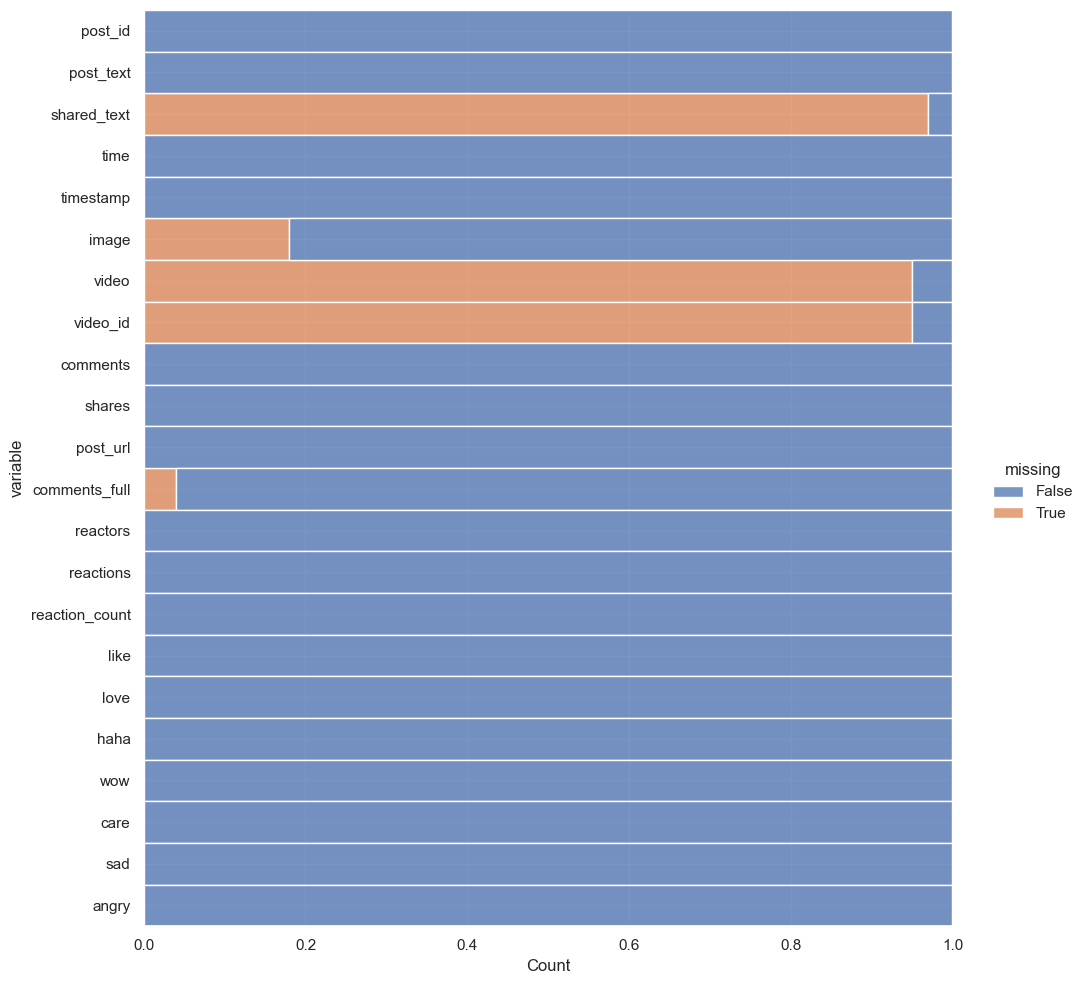

In [147]:
# Data completeness 
sns.displot(
    data=df.isna().melt(value_name="missing"),
    height=10,
    y='variable',
    hue='missing',
    multiple='fill',
    aspect=1
)

<Axes: xlabel='hour', ylabel='post counts'>

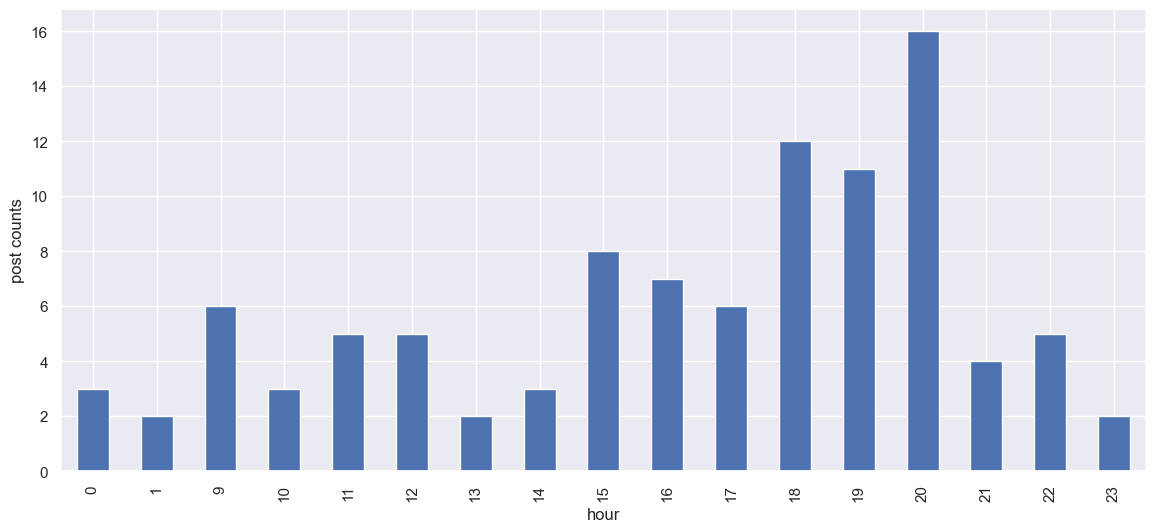

In [219]:
# Quantity of post in relation to time

hour_series = df['time'].apply(lambda x : x.hour)
df['hour'] = hour_series
pd.concat([df, df['hour']], axis=1)

df['hour'].value_counts().sort_index().plot(kind='bar', figsize=(14,6),
                                            ylabel='post counts')


Số lượng post được đăng nhiều nhất là vào khoảng 20h

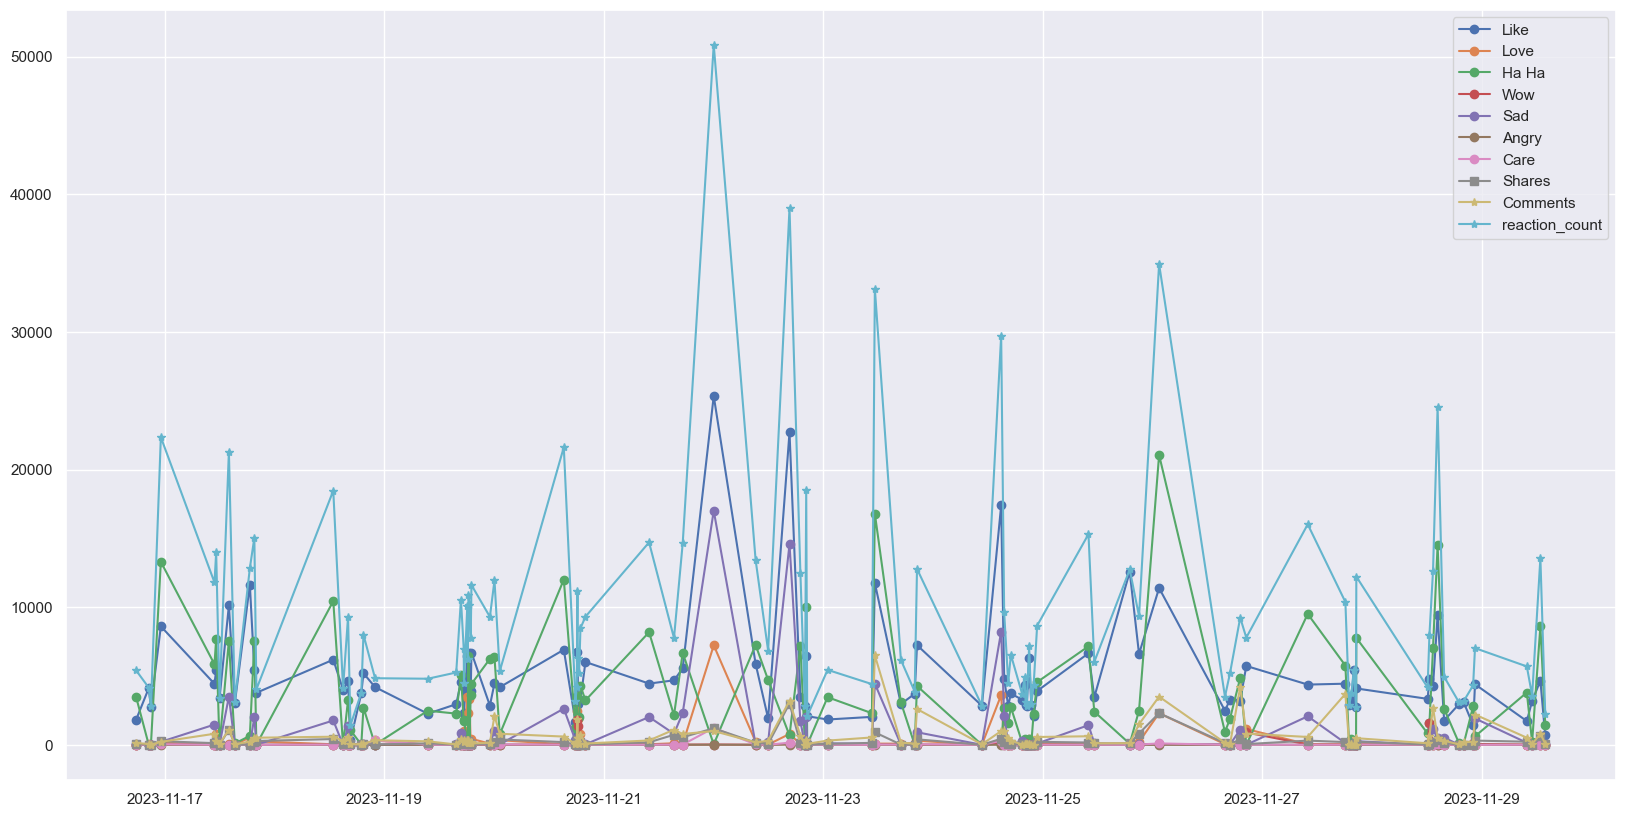

In [211]:
# Reactions over time
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(df['time'], df['like'], label = "Like", marker="o")
ax.plot(df['time'], df['love'], label = "Love", marker="o")
ax.plot(df['time'], df['haha'], label = "Ha Ha", marker="o")
ax.plot(df['time'], df['wow'], label = "Wow", marker="o")
ax.plot(df['time'], df['sad'], label = "Sad", marker="o")
ax.plot(df['time'], df['angry'], label = "Angry", marker="o")
ax.plot(df['time'], df['care'], label = "Care", marker="o")
ax.plot(df['time'], df['shares'], label = "Shares", marker="s")
ax.plot(df['time'], df['comments'], label = "Comments", marker="*")
ax.plot(df['time'], df['reaction_count'], label = "reaction_count", marker="*")

plt.legend()

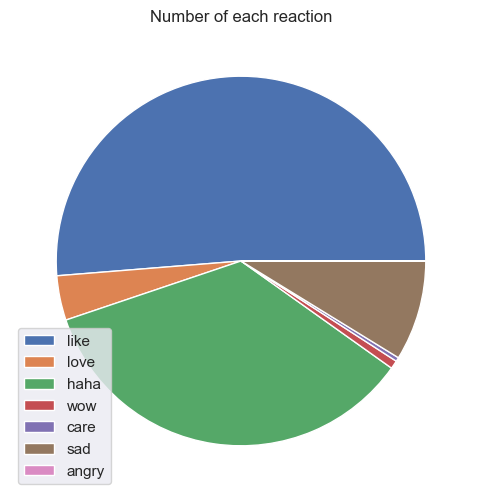

In [243]:
reaction_count = df[['like', 'love', 'haha', 'wow', 'care', 'sad', 'angry']]
my_label = reaction_count.columns
plt.pie(reaction_count.sum())
plt.legend(my_label)
plt.title('Number of each reaction')
plt.show()

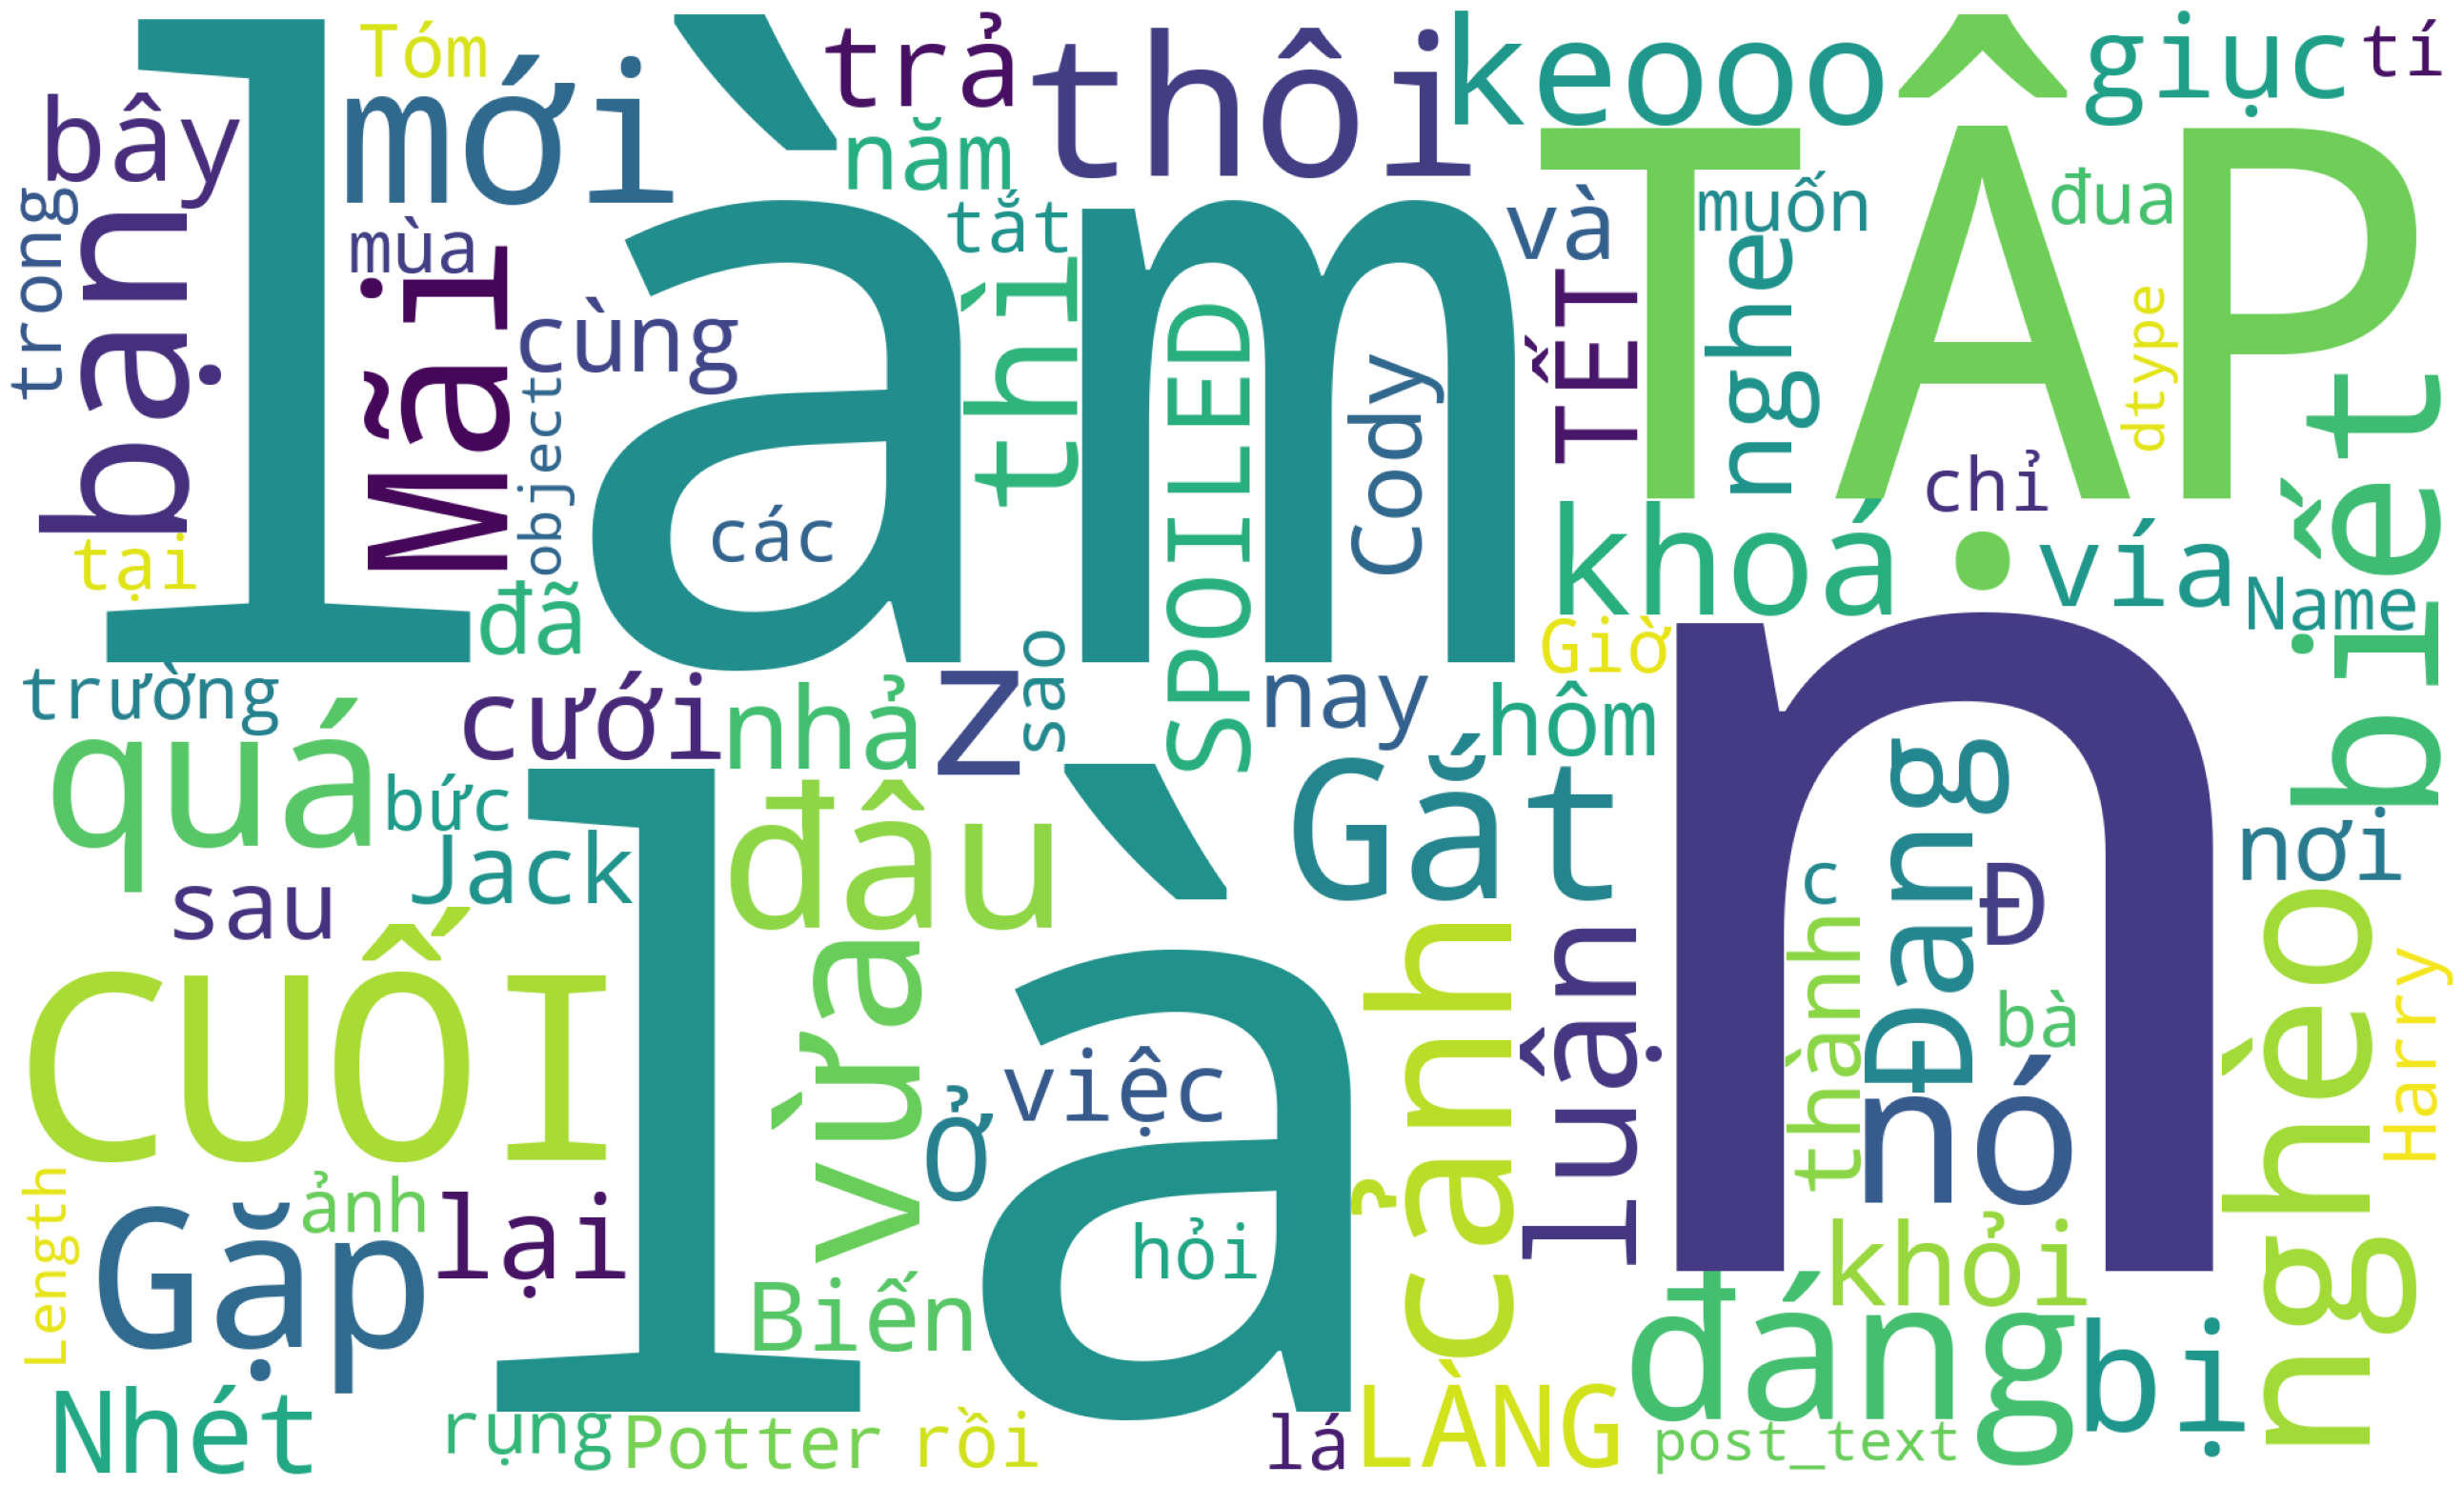

In [194]:
# Stop words
from wordcloud import WordCloud, STOPWORDS

text = str(df['post_text'])

wordcloud = WordCloud(stopwords=STOPWORDS,
                        background_color='white', 
                    max_words=500,
                    width=2000, height=1200
                        ).generate(text)
plt.figure(figsize=(40,20))
plt.clf()
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [20]:
X = np.array(df[['reaction_count', 'comments']])
Y = np.array(df[['hour']])
print(X.shape, Y.shape)   

(100, 2) (100, 1)


In [21]:
norm_l = tf.keras.layers.Normalization(axis=-1)
norm_l.adapt(X)
Xn = norm_l(X)

Xt = np.tile(Xn,(1000,1))
Yt = np.tile(Y,(1000,1))
print(Xt.shape, Yt.shape)   


(100000, 2) (100000, 1)


In [37]:
tf.random.set_seed(1234)
model = Sequential(
    [
        tf.keras.Input(shape=(2,)),
        Dense(3, activation='sigmoid', name='layer1'),
        Dense(1, activation='sigmoid', name='layer2')
    ]
)

In [38]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, 3)                 9         
                                                                 
 layer2 (Dense)              (None, 1)                 4         
                                                                 
Total params: 13 (52.00 Byte)
Trainable params: 13 (52.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [39]:
w1, b1 = model.get_layer('layer1').get_weights()
w2, b2 = model.get_layer('layer2').get_weights()
print(f"W1{w1.shape}:\n", w1, f"\nb1{b1.shape}:", b1)
print(f"W2{w2.shape}:\n", w2, f"\nb2{b2.shape}:", b2)

W1(2, 3):
 [[-0.18544692 -0.9989357  -0.19282562]
 [ 0.8229083  -0.12550294 -0.17543507]] 
b1(3,): [0. 0. 0.]
W2(3, 1):
 [[ 0.41760194]
 [ 0.7055626 ]
 [-0.09311414]] 
b2(1,): [0.]


In [40]:
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01),
)

model.fit(
    Xt, Yt,
    epochs=10,
)

Epoch 1/10
3125/3125 [==============================] - 3s 833us/step - loss: -1033.1211
Epoch 2/10
3125/3125 [==============================] - 3s 818us/step - loss: -2993.8557
Epoch 3/10
3125/3125 [==============================] - 3s 816us/step - loss: -4937.7295
Epoch 4/10
3125/3125 [==============================] - 3s 823us/step - loss: -6881.5381
Epoch 5/10
3125/3125 [==============================] - 3s 809us/step - loss: -8824.7051
Epoch 6/10
3125/3125 [==============================] - 3s 847us/step - loss: -10769.2803
Epoch 7/10
3125/3125 [==============================] - 3s 821us/step - loss: -12712.6553
Epoch 8/10
3125/3125 [==============================] - 2s 796us/step - loss: -14655.9717
Epoch 9/10
3125/3125 [==============================] - 2s 792us/step - loss: -16600.3828
Epoch 10/10
3125/3125 [==============================] - 3s 839us/step - loss: -18544.2500


In [41]:
X_test = np.array([
    [122,12],  # postive example
    [10,0]    # negative example
    ])   
X_testn = norm_l(X_test)
predictions = model.predict(X_testn)
print("predictions = \n", predictions)

1/1 [==============================] - 0s 42ms/step
predictions = 
 [[1.]
 [1.]]


In [42]:
yhat = np.zeros_like(predictions)
for i in range(len(predictions)):
    if predictions[i] >= 0.5:
        yhat[i] = 1
    else:
        yhat[i] = 0
print(f"decisions = \n{yhat}")

decisions = 
[[1.]
 [1.]]
